# Comparisson of ML Algorithms for Image Classification

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.io import imread
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
import seaborn as sns
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score,recall_score,precision_score,make_scorer,accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import random
import pickle

In [3]:
np.random.seed(42)

### Short Description of the projet

In the current work three Machine Learning algorithms will be compared based on how they perform on image classification - Logistic Regression, Random Forest and Adaptive Boosting Classifier (AdaBoost). The dataset consists of two types of animals - cats and dogs. The image sets are taken from Kaggle. There are 12500 cats and 12500 dogs. This is a very standard ML problem with thousands of solutions that can be found online, mainly using CNN. Examples are: [Cats and Dogs1](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification), [Cats and Dogs2](https://www.kaggle.com/jaydeepsb/cnn-95-val-acc-without-transfer-learning) and many others.

### DATA PREPARATION

In [4]:
# this is the folder with training data which is labeled

training_folder_cats_dogs='data/train_cats_dogs/'

cat_images=[]
dog_images=[]


The images will be imported as color images and histogram equalization will be applied to them. The latter is used in order to incerase the contrast of the pictures which is supposed to give better results in the ML model training later. The effect of histogram equalization can be seen in the images below.

This is the original picture of a cat.

In [5]:
cat_img=cv2.imread(training_folder_cats_dogs+'cat.1.jpg',cv2.IMREAD_COLOR)

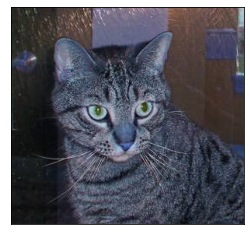

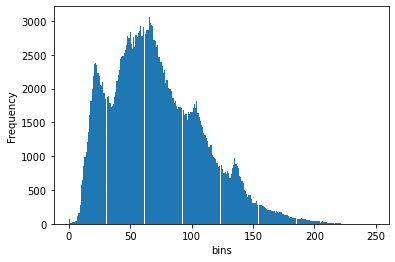

In [6]:
plt.imshow(cat_img)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()
plt.hist(cat_img.ravel(),bins=256)
plt.xlabel('bins')
plt.ylabel('Frequency')
plt.show()

And here is the effect of applying histogram equalization.

In [7]:
img_hsv=cv2.cvtColor(cat_img, cv2.COLOR_RGB2HSV)
img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
cat_img_heq=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

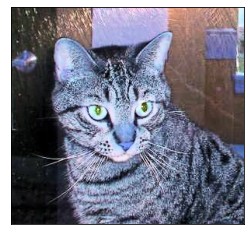

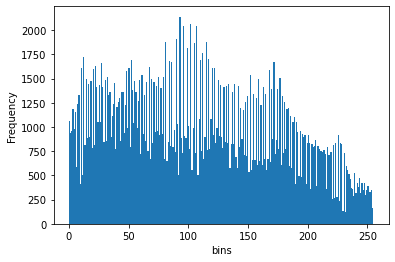

In [8]:
plt.imshow(cat_img_heq)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()
plt.hist(cat_img_heq.ravel(),bins=256)
plt.xlabel('bins')
plt.ylabel('Frequency')
plt.show()

Following is the definition of the function which performes the images import and histogram equalization operation.

In [9]:
def import_pictures(image_size):
#equalized histograms
    
    
    global cat_images
    global dog_images
   
    cat_images=[]
    dog_images=[]
    
    for file in os.listdir(training_folder_cats_dogs):
        if 'cat' in file:
            
            img_cat=cv2.imread(training_folder_cats_dogs+str(file),cv2.IMREAD_COLOR)
            
            img_hsv=cv2.cvtColor(img_cat, cv2.COLOR_RGB2HSV)
            img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
            img_cat=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
            
            img_cat_resized=cv2.resize(img_cat,(image_size,image_size)).ravel()
            img_cat_labeled=np.append(img_cat_resized,1)
            cat_images.append(img_cat_labeled)
        
        if 'dog' in file:
        
            img_dog=cv2.imread(training_folder_cats_dogs+str(file),cv2.IMREAD_COLOR)
            
            img_hsv=cv2.cvtColor(img_dog, cv2.COLOR_RGB2HSV)
            img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
            img_dog=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
            
            img_dog_resized=cv2.resize(img_dog,(image_size,image_size)).ravel()
            img_dog_labeled=np.append(img_dog_resized,0)
            dog_images.append(img_dog_labeled)
    
    
    cat_images=np.array(cat_images)
    dog_images=np.array(dog_images)
   
    
    print (cat_images.shape,dog_images.shape) 
    
    data_set=np.concatenate((cat_images,dog_images),axis=0) 
    np.random.shuffle(data_set)
    
    return data_set

In [10]:
def take_data_subset(subset_size,cat_images,dog_images): 
    
    
    subset_size_cat=int(subset_size*len(cat_images))
    subset_size_dog=int(subset_size*len(dog_images))
   
    subset_cat=cat_images[:subset_size_cat,:]
    subset_dog=dog_images[:subset_size_dog,:]
    
    subset_data_set=np.concatenate((subset_cat,subset_dog),axis=0) 
     
    np.random.shuffle(subset_data_set)
        
           
    return subset_data_set

In [11]:
image_size=40
data_set=import_pictures(image_size)


(12500, 4801) (12500, 4801)


In [12]:
len(cat_images)

12500

In [13]:
len(dog_images)

12500

Everything is OK with the separate sets' lengths, so we will continue with some checks of the complete training set.

In [14]:
data_set.shape

(25000, 4801)

In [15]:
data_set[:,:-1].max()

255

Below, the set will be split between features (training_set_features) and the target variable (training_set_target) which are actually the classes.

In [16]:
data_set_features=data_set[:,:-1]

In [17]:
data_set_features.shape

(25000, 4800)

In [18]:
data_set_target=data_set[:,-1]

In [19]:
data_set_target.shape

(25000,)

Following is the train and test split. We are doing it before other data processing, like scaling and PCA, because we would like to have them fit first only on the training data and then apply the transform on the testing set. In this way data leakage is evaded (even if it will not have a significant effect). 


In [20]:
 X_train,X_test,y_train,y_test=train_test_split(data_set_features,data_set_target,test_size=0.2,stratify=data_set_target)

Again some checks of the shape of both sets is made in order to make sure the split was made correctly.

In [22]:
X_train.shape,y_train.shape

((20000, 4800), (20000,))

In [23]:
X_test.shape,y_test.shape

((5000, 4800), (5000,))

### PCA

PCA will be applied without limitation of the number of PCs in order to check the number of PCs which give explained variance ratio of at least 95%. That value of principal components will be used later in the dimentionality reduction step. For PCA it is very important the data to be scaled, that's why a Standard Scaler will be used here on the X_train. Later this step is included in the pipeline. 

In [24]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)

In [25]:
pca=PCA()

In [26]:
pca.fit(X_train_scaled)

PCA()

In [27]:
pca_cumsum=np.cumsum(pca.explained_variance_ratio_)

In [29]:
sns.set()

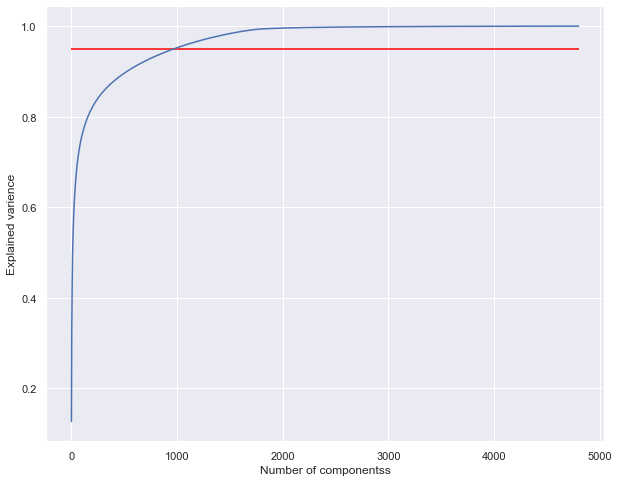

In [30]:
plt.figure(figsize=(10,8))
plt.plot(range(len(pca_cumsum)),pca_cumsum)
plt.hlines(0.95,0,len(pca_cumsum),color='red')
plt.xlabel("Number of componentss")
plt.ylabel("Explained varience")
plt.show()

The number of primary components for which the explaind variance ratio is 95% is about 1000.

### LOGISTIC REGRESSION

#### Short Description of the model

This algorithm is commonly used for classification purposes because it can estimate the probability of an instance belonging to a specific category. The simplest type is the binary logistic regression where we have only two categories (or classes). Usually, they are denoted by "1" and "0". The logic is that if the estimated probability is above 50% then the model predicts that the sample belongs to a specified class, usually considered the positive one and denoted by "1". And vise versa.

In order for such an algorithm to work properly, a suitable activation function is needed. Again, as in Linear Regression, a weighted sum of the input features is calculated but instead of outputting the result directly, it is submitted to a sigmoid function $\sigma(z)$:

$$\sigma(z)=\frac{1}{1+e^{-z}}$$

This function outputs a number between 0 and 1 and is defined in the range ${(-\infty}$ ${+\infty)}$.
If we have the array X of our input data and ${\theta}$ of the feature weights, then ${z=X*\theta}$

$$X=\left\lgroup \matrix{x_{11}&x_{12}&\cdots&x_{1n} \\ x_{21}&x_{22}&\cdots&x_{2n} \\ \vdots&\vdots&\ddots&\vdots \\ x_{m1}&x_{m2}&\cdots&x_{mn}} \right\rgroup$$

$$\theta=\left\lgroup \matrix{\theta_1 \\ \theta_2 \\ \vdots \\ \theta_n}\right\rgroup$$

X has dimentionality m x n: m samples, n features.

In order to take into account of the intercept we have to add $\theta_0$ and in order to do vector/matrix multiplication and addition we also have to add one more column in X (for $x_0)$, a column of all ones which will multiply $\theta_0$. So X and $\theta$ matrices will look like this:

$$X=\left\lgroup \matrix{1&x_{11}&x_{12}&\cdots&x_{1n} \\ 1&x_{21}&x_{22}&\cdots&x_{2n} \\ \vdots&\vdots&\ddots&\vdots \\ 1&x_{m1}&x_{m2}&\cdots&x_{mn}} \right\rgroup$$

$$\theta=\left\lgroup \matrix{\theta_0 \\ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n}\right\rgroup$$

Then our hypothesis for the $i^{-th} sample$ will be: $$h_{\theta}(x^{i}) \ \ = \ \ 1*\theta_0+x_{i1}*\theta_1+x_{i2}*\theta_2+\cdots+x_{in}*\theta_n$$


With y we will denote the outcomes (classes).

The function $ \ \ h_{\theta}(x) \ \ = \ \ \sigma(z) \ \ = \sigma(X*\theta)$ we will denote as the hypothesis of our predictions.

So the sigmoid for logistic regression will look like this: $$\sigma(z)=\frac{1}{1+e^{-\theta*X}}$$


![sig](Sigmoid.jpg)


Once the model has estimated the probablity $\hat{p}=h_{\theta}(x) $, it can make its prediction $\hat{y}$ as following:
$$\hat{y}=\Bigg\{ \matrix{1 \ \ if \ \ \hat{p}\ \ \geqslant	\ \ 0.5 \\ 0 \ \ if \ \ \hat{p}\ \ < \ \ 0.5}$$


From the graph above, we can see that $\ \ \sigma(z) \ \ < 0.5 \ \ $ when $\ \ z \ \ < \ \ 0 \ \ $  and $\ \ \sigma(z) \ \ \geqslant \ \ 0.5 \ \ $ when $\ \ z \ \ \geqslant \ \ 0$

### Modelling Function

Below is the function model_training which takes as arguments the model and its hyperparameters, applies the pipeline on the training set and returns the result of training the model. A separate function "show_results" is defined for presenting the results of the model training.

f1-score will be used, since we have classification task and sometimes accuracy can be misleading. 

In [31]:
def model_training(estimator,param_grid,X_train,y_train,X_test,y_test):
    scaler=StandardScaler()
    pca=PCA(random_state=42)
    pipe=Pipeline(steps=[('scaler',scaler),('pca',pca),('model',estimator)])
    score=make_scorer(f1_score,average='macro')
    search=GridSearchCV(pipe, param_grid, scoring=score,cv=5,verbose=0,n_jobs=3)
    
    search.fit(X_train,y_train)
    pipe.set_params(**search.best_params_)
    
    pipe.fit(X_train,y_train)
    
    train_pred=pipe.predict(X_train)
    test_pred=pipe.predict(X_test)
    
    
    return search.best_estimator_,search.cv_results_,train_pred,y_train,test_pred,y_test,classification_report

In [32]:
def show_results(best_estimator,cv_results,train_pred,y_train,test_pred,y_test):
    
    print("_______________________________________________________________________")
    print("BEST ESTIMATOR")
    print(best_estimator)
    print("_______________________________________________________________________")
    print("CV RESULTS")
    print (cv_results)

    print("_______________________________________________________________________")
    print("Classification Results Train Set")
    print(classification_report(train_pred,y_train))
    print("_______________________________________________________________________")
    print("Classification Results Test Set")
    print(classification_report(test_pred,y_test))
    labels=['Dogs','Cats']
    mat = confusion_matrix(y_test,test_pred)
    sns.heatmap(mat, square=True, annot=True, cbar=False,cmap='Blues',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted value')
    plt.ylabel('True value');

The draw_learning_curve function is used to take part of the data set, train the model and calculate the errors. Thus, giving the dependancy between number of samples seen by the model and the achieved error. 

In [33]:
def draw_learning_curve(estimator,params):
    
    cv_error=[]
    train_error=[]
    test_error=[]
    val_error=[]
    
    n_components=int(params['pca__n_components'][0])
    
    for i in range(5,105,5):
        i=i*0.01
        nb_samples=int(i*len(X_train)*0.7)
        
        pc_num=min(nb_samples,n_components)
        temp_training=take_data_subset(i,cat_images,dog_images) #,zebra_images,elephant_images)
        temp_training_features=temp_training[:,:-1]
        temp_training_target=temp_training[:,-1]
        X_train_temp,X_test_temp,y_train_temp,y_test_temp=train_test_split(temp_training_features,temp_training_target,test_size=0.3,stratify=temp_training_target)
       
        best_estimator_mod,cv_results_mod,train_pred_mod,y_train_mod,test_pred_mod,y_test_mod,cl_rep_mod=model_training(
        estimator,params,X_train_temp,y_train_temp,X_test_temp,y_test_temp)
        sc_train=f1_score(y_train_mod,train_pred_mod,average='macro')
        sc_test=f1_score(y_test_mod,test_pred_mod,average='macro')
        #cv_error.append(1-cv_results_mod['mean_test_score'])
        train_error.append(round((1-sc_train),2))
        test_error.append(round((1-sc_test),2))
        val_error.append(round((1-cv_results_mod['mean_test_score'][0]),2))
    
    
    print ("Validation error: ",val_error)
    print ("Train error: ",train_error)
    print ("Test error: ",test_error)
    x=range(5,105,5)
    plt.plot(x,val_error,label="Validation Error")
    plt.plot(x,train_error,label="Train Error")
    plt.plot(x,test_error,label="Test Error")
    plt.ylim(0,0.6)
    plt.xlabel("Percentage of total data samples, %")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

In [34]:
X_train.shape,y_train.shape

((20000, 4800), (20000,))

The first model we will train is Logistic Regression. In order to choose the most appropriate model hyper parameters, a Grid Search will be performed. The values to choose from and combine in the model are given in the dictionary param_grid_LR.

In [36]:
param_grid_LR={'model__C':[1e-2,1e-1,1],
               'model__penalty':['l2','l1'],
               'model__solver':['saga'],
               'model__max_iter':[1000],
               'pca__n_components':[1000]
              }

best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR,cl_rep_LR=model_training(LogisticRegression(),param_grid_LR,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=1000, random_state=42)),
                ('model',
                 LogisticRegression(C=0.01, max_iter=1000, penalty='l1',
                                    solver='saga'))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([197.1658494 , 207.64272265, 210.29180317, 229.17267346,
       211.97587438, 242.50106654]), 'std_fit_time': array([11.61607713,  3.65402034,  5.19034621,  2.14891755, 21.64795952,
       27.60744372]), 'mean_score_time': array([2.83180299, 2.72827339, 3.43728313, 2.6429574 , 3.57403955,
       4.02579374]), 'std_score_time': array([0.3548238 , 0.45601139, 0.19736509, 0.26720507, 0.60885975,
       1.23747512]), 'param_model__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1],
             mask=[False, False, False, False, False, Fals

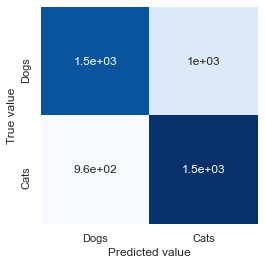

In [37]:
show_results(best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR)

The best model chosen by Grid Search is the one with C=0.01 and penalty=l1. The mean validation score for the model is 0.61.

In [38]:
cv_results_LR['rank_test_score']

array([3, 1, 5, 2, 6, 4])

In [39]:
cv_results_LR['mean_test_score']

array([0.59984875, 0.61393955, 0.59735428, 0.60178129, 0.59675074,
       0.59784921])

The chosen value of C is the left most value in the list [1e-2,1e-1,1]. In this case it is good to run another Grid Search and chose a new list of values for C, where 0.01 will be in the middle of the list: [1e-3,1e-2,1e-1]

In [40]:
param_grid_LR={'model__C':[1e-3,1e-2,1e-1],
               'model__penalty':['l2','l1'],
               'model__solver':['saga'],
               'model__max_iter':[1000],
               'pca__n_components':[1000]
              }

best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR,cl_rep_LR=model_training(LogisticRegression(),param_grid_LR,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=1000, random_state=42)),
                ('model',
                 LogisticRegression(C=0.01, max_iter=1000, penalty='l1',
                                    solver='saga'))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([268.55362577, 304.41885433, 312.17454944, 266.94994335,
       288.2554882 , 327.34391356]), 'std_fit_time': array([18.74828071,  9.16980343,  4.22535214, 21.98652732, 22.76818371,
        6.26818607]), 'mean_score_time': array([3.976404  , 3.60481744, 5.47081547, 4.41006222, 5.21727381,
       4.9525589 ]), 'std_score_time': array([0.21010837, 0.27010529, 1.23492418, 0.80417437, 0.87332083,
       1.26223384]), 'param_model__C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1],
             mask=[False, False, False, False, Fal

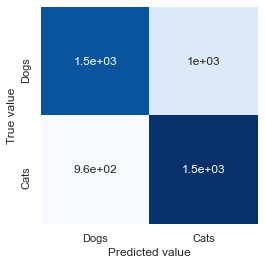

In [41]:
show_results(best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR)

It still sticks to the 0.01 value.
From the classification report it can be seen that the training set has score 0.64, while validation set score is 0.61. Which means a little bit overfitting is there. We will try to remove it by manually fine-tuning the model's hyper parametrs.

In order to make the model little bit worse in fitting the data, we will decrease the parameter C to 0.001 and decrease the number of primary components and check which way gives better results (less overfitting).

#### n_components=100

In [42]:
param_grid_LR={'model__C':[0.01],
               'model__penalty':['l1'],
               'model__solver':['saga'],
               'model__max_iter':[1000],
               'pca__n_components':[100]
              }

best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR,cl_rep_LRp=model_training(LogisticRegression(),param_grid_LR,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=100, random_state=42)),
                ('model',
                 LogisticRegression(C=0.01, max_iter=1000, penalty='l1',
                                    solver='saga'))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([46.80869355]), 'std_fit_time': array([5.08678791]), 'mean_score_time': array([1.09832015]), 'std_score_time': array([0.11867969]), 'param_model__C': masked_array(data=[0.01],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__max_iter': masked_array(data=[1000],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__penalty': masked_array(data=['l1'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__solver': masked_arra

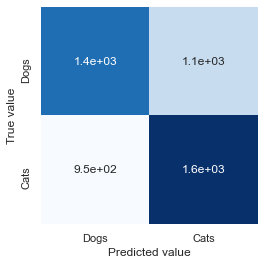

In [43]:
show_results(best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR)

The result is: Train score: 0.61, Validation score: 0.60, Test score: 0.59

#### C=0.001

In [44]:
param_grid_LR={'model__C':[0.001],
               'model__penalty':['l2'],
               'model__solver':['saga'],
               'model__max_iter':[1000],
               'pca__n_components':[1000]
              }

best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR,cl_rep_LR=model_training(LogisticRegression(),param_grid_LR,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=1000, random_state=42)),
                ('model',
                 LogisticRegression(C=0.001, max_iter=1000, solver='saga'))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([245.87358885]), 'std_fit_time': array([60.58940637]), 'mean_score_time': array([4.56100116]), 'std_score_time': array([0.91680905]), 'param_model__C': masked_array(data=[0.001],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__max_iter': masked_array(data=[1000],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__penalty': masked_array(data=['l2'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__solver': masked_array(data=['saga'],
             mask=[False],
 

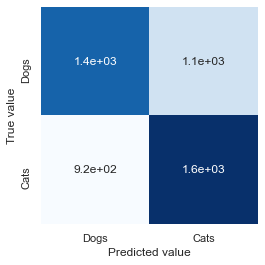

In [45]:
show_results(best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR)

The result is: Train score: 0.66, Validation score: 0.61, Test score: 0.60

The second model has bigger overfitting. For this reason, we will choose the one with less PCs.

And finally, we will do one more grid search with 3 values of C but not on the exponential scale.

In [46]:
param_grid_LR={'model__C':[0.005,0.01,0.02],
               'model__penalty':['l2','l1'],
               'model__solver':['saga'],
               'model__max_iter':[1000],
               'pca__n_components':[100]
              }

best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR,cl_rep_LR=model_training(LogisticRegression(),param_grid_LR,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=100, random_state=42)),
                ('model',
                 LogisticRegression(C=0.02, max_iter=1000, penalty='l1',
                                    solver='saga'))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([38.74021969, 39.52936406, 44.92711282, 47.03318968, 45.97569714,
       45.66799092]), 'std_fit_time': array([0.41264159, 2.33315832, 1.10481475, 0.14288336, 0.3510274 ,
       0.14966864]), 'mean_score_time': array([1.01183138, 0.99861355, 1.07086434, 1.06572256, 0.99089828,
       0.9359777 ]), 'std_score_time': array([0.08564524, 0.08697343, 0.04198296, 0.07305118, 0.08323074,
       0.08837269]), 'param_model__C': masked_array(data=[0.005, 0.005, 0.01, 0.01, 0.02, 0.02],
             mask=[False, False, False, False, False, False],

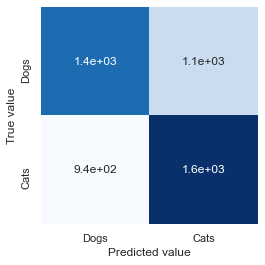

In [47]:
show_results(best_estimator_LR,cv_results_LR,train_pred_LR,y_train_LR,test_pred_LR,y_test_LR)

The result now is: Train set score: 0.61, Validation score: 0.60, Test Score:0.59.
Same as the model with C=0.01, penalty=l1 and n_components=100

#### Final result from Logistic Regression Model Training

C=0.01, penalty='l1', n_components=100
Train score=0.61, Validation score=0.6, Test score=0.59

Let's now see the learning curve.

In [48]:
params_LR={'model__C':[0.01],
           'model__penalty':['l1'],
           'model__solver':['saga'],
           'model__max_iter':[1000],
           'pca__n_components':[100]
            }

Validation error:  [0.43, 0.4, 0.43, 0.42, 0.4, 0.41, 0.41, 0.41, 0.41, 0.4, 0.41, 0.42, 0.41, 0.4, 0.4, 0.41, 0.41, 0.4, 0.4, 0.4]
Train error:  [0.38, 0.37, 0.4, 0.41, 0.38, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.4, 0.39, 0.39, 0.4, 0.4, 0.4, 0.4, 0.39, 0.4]
Test error:  [0.4, 0.46, 0.4, 0.42, 0.44, 0.42, 0.41, 0.41, 0.4, 0.42, 0.42, 0.4, 0.41, 0.41, 0.41, 0.41, 0.4, 0.4, 0.41, 0.4]


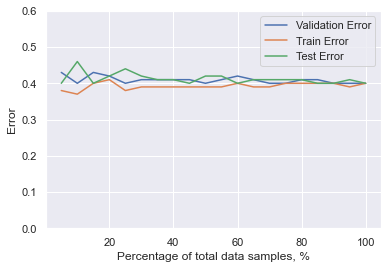

In [49]:
draw_learning_curve(LogisticRegression(),params_LR)

### RANDOM FOREST

In order to understand Random Forest Classifier one should get to know Decision Trees first.

Decision Trees are used mainly for classification. It puts data samples in groups after "asking qustions" and splitting the samples according to their "answers".[2]


![dec_tr1](dec_tr1.JPG)




If represented on a graph it looks like it draws lines on the plane (in case of 2 dimentional data) which divide the data belonging to different classes [4]. 

![RF1](RF1.JPG)

The splitting of data terminates when:

* Either it has been divided into classes that are pure (only containing members of single class )
* Some criteria of classifier attributes are met.

Sometimes classes cannot be separated so well. There might be traces of one class into another. This is called Impurity. It can appear due to following reasons:

* We ran out of available features to divide the class upon.
* We tolerate some percentage of impurity (we stop further division) for faster performance.

![dec_tr3](dec_tr3.JPG)


There are two measures of impurity:

* Gini index and
* Entropy


#### Random Forest

As stated in [5] Random Forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest splts out a class prediction and the class with the most votes becomes our model’s prediction. The fundamental concept behind random forest is a simple but powerful one — the wisdom of crowds. In data science speak, the reason that the random forest model works so well is:
A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models.
The low correlation between models is the key. 

![RF2.jpg](RF2.JPG)


In order to assuse for low correlation, Random Forest allows each individual tree to randomly sample from the dataset with replacement, resulting in different trees. This process is known as bagging.
Notice that with bagging we are not subsetting the training data into smaller chunks and training each tree on a different chunk. Rather, if we have a sample of size N, we are still feeding each tree a training set of size N (unless specified otherwise). But instead of the original training data, we take a random sample of size N with replacement. 

In a normal decision tree, when it is time to split a node, we consider every possible feature and pick the one that produces the most separation between the observations in the left node vs. those in the right node. In contrast, each tree in a random forest can pick only from a random subset of features. This forces even more variation amongst the trees in the model and ultimately results in lower correlation across trees and more diversification.

So in our random forest, we end up with trees that are not only trained on different sets of data (thanks to bagging) but also use different features to make decisions. And this is what creates uncorrelated trees, 

At the beggining of model training again we will start with Grid Search.

In [51]:
param_grid_RF={
    'model__max_depth': [2,5,8],
    'model__n_estimators': [200,400,600],
    'pca__n_components':[1000]
}

best_estimator_rf,cv_results_rf,train_pred_rf,y_train,test_pred_rf,y_test_rf,cl_rep=model_training(RandomForestClassifier(),param_grid_RF,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=1000, random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=8, n_estimators=600))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([336.65425339, 352.71859188, 355.53755956, 295.20885324,
       351.07789292, 424.7263732 , 304.76580873, 393.04488559,
       436.32169814]), 'std_fit_time': array([ 4.68616702, 24.7516211 , 23.04898788,  8.02985165, 21.12011402,
       16.29562303, 11.90398615, 14.34958675, 22.65171068]), 'mean_score_time': array([4.72027874, 5.21814466, 5.51070976, 4.04887667, 3.38431225,
       3.6838201 , 3.45994153, 3.1674366 , 3.05277729]), 'std_score_time': array([1.19776608, 1.98086228, 1.5751617 , 1.34991947, 0.51501456,
       0.43857102, 0.39670772, 0.25585103, 0.4473087 ]), 'param_model__max

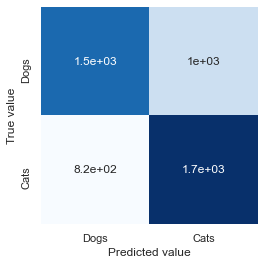

In [52]:
show_results(best_estimator_rf,cv_results_rf,train_pred_rf,y_train,test_pred_rf,y_test_rf)

The Grid Search chose a model with max_depth=8 and number of estimators=600. But we can see that it gives quite nice overfitting. The train set score is 0.81, the Validation set score - 0.63 and the Test set score - 0.63. So, lets "worsen" the model little bit. Will try first with reducing the max_depth to 5.

In [53]:
param_grid_RF={
    'model__max_depth': [5],
    'model__n_estimators': [600],
    'pca__n_components':[1000]
}

best_estimator_rf,cv_results_rf,train_pred_rf,y_train_rf,test_pred_rf,y_test_rf,cl_rep_rf=model_training(RandomForestClassifier(),param_grid_RF,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=1000, random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=600))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([438.77121668]), 'std_fit_time': array([67.14640385]), 'mean_score_time': array([4.98416128]), 'std_score_time': array([0.55894994]), 'param_model__max_depth': masked_array(data=[5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__n_estimators': masked_array(data=[600],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_pca__n_components': masked_array(data=[1000],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'model__max_depth': 5, 'model__n_estimators': 600, 'pca__n_co

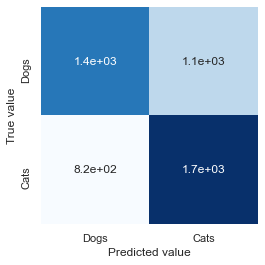

In [54]:
show_results(best_estimator_rf,cv_results_rf,train_pred_rf,y_train_rf,test_pred_rf,y_test_rf)

The overfitting decreased but still it is too high. Next step will be to decrease the number of features - primary components in this case from 1000 to 100.

In [55]:
param_grid_RF={
    'model__max_depth': [5],
    'model__n_estimators': [600],
    'pca__n_components':[100]
}


best_estimator_rf,cv_results_rf,train_pred_rf,y_train_rf,test_pred_rf,y_test_rf,cl_rep_rf=model_training(RandomForestClassifier(),param_grid_RF,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=100, random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=5, n_estimators=600))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([99.66363578]), 'std_fit_time': array([19.50453075]), 'mean_score_time': array([1.20688186]), 'std_score_time': array([0.180111]), 'param_model__max_depth': masked_array(data=[5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__n_estimators': masked_array(data=[600],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_pca__n_components': masked_array(data=[100],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'model__max_depth': 5, 'model__n_estimators': 600, 'pca__n_compone

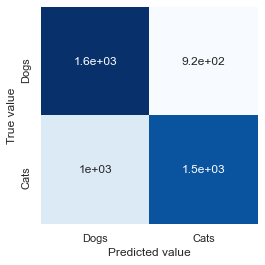

In [56]:
show_results(best_estimator_rf,cv_results_rf,train_pred_rf,y_train_rf,test_pred_rf,y_test_rf)

Again the overfitting is too big and new values of hyper parameters should be tried. Several experiments were made, not shown here. The best result was achievd for max_depth=2, n_estimators=600 and n_components=80. In this case Train set error is 0.62, Validation set error is 0.61 and Test set error - 0.6.

In [57]:
param_grid_RF={
    'model__max_depth': [2],
    'model__n_estimators': [600],
    'pca__n_components':[80]
}


best_estimator_rf,cv_results_rf,train_pred_rf,y_train_rf,test_pred_rf,y_test_rf,cl_rep_rf=model_training(RandomForestClassifier(),param_grid_RF,X_train,y_train,X_test,y_test)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=80, random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=2, n_estimators=600))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([62.49363918]), 'std_fit_time': array([7.9403874]), 'mean_score_time': array([1.31619215]), 'std_score_time': array([0.38711667]), 'param_model__max_depth': masked_array(data=[2],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__n_estimators': masked_array(data=[600],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_pca__n_components': masked_array(data=[80],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'model__max_depth': 2, 'model__n_estimators': 600, 'pca__n_component

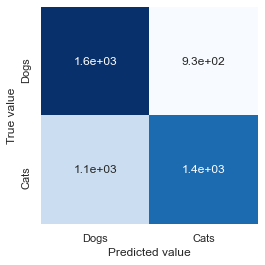

In [58]:
show_results(best_estimator_rf,cv_results_rf,train_pred_rf,y_train_rf,test_pred_rf,y_test_rf)

The final result of Random Forest training is a model with max_depth=2, n_estimators=600 and n_components=80 which gives Train set error 0.62, Validation set error 0.60 and Test set error 0.60.

Now we will draw the learning curve.

Validation error:  [0.41, 0.41, 0.42, 0.41, 0.41, 0.41, 0.4, 0.39, 0.4, 0.41, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
Train error:  [0.18, 0.27, 0.3, 0.31, 0.35, 0.35, 0.36, 0.35, 0.36, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.38, 0.37, 0.38, 0.38]
Test error:  [0.46, 0.39, 0.42, 0.41, 0.42, 0.39, 0.39, 0.39, 0.39, 0.4, 0.41, 0.4, 0.39, 0.39, 0.39, 0.41, 0.39, 0.41, 0.4, 0.39]


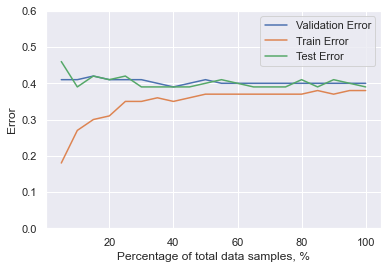

In [59]:
params_RF={
    'model__max_depth': [2],
    'model__n_estimators': [600],
    'pca__n_components':[80]
}


draw_learning_curve(RandomForestClassifier(),params_RF)

### Adaptive Boosting Classifier (AdaBoost)

A kind of "upgrade" of Random Forest is the AdaBoost algorithm. While Random Forest splits the data and trains several models in paralel, Adaptive Boosting (and other boosting algorithms in general) has a different approach. It uses a base learner (a ML algorithm which is a weak learner) and improves the areas where it fails. Usually, the base learners are Decision Stumps - trees with max_depth=1. The first one takes random samples of the data and classifies them. After that the Decision Stump is fit to the complete training data set. The next stump is fed with the complete training set where the correctly classified samples are given less weight and the misclassified ones are given higher weights. This process is done iteratively until either data is fit perfectly or the maximum number of estimators is reached.

In [60]:
tree=DecisionTreeClassifier(max_depth=1)

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=100, random_state=42)),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.1, n_estimators=800))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([166.90872803, 244.57644606, 267.36963601, 143.09743624,
       226.88264861, 322.85904703, 175.12701416, 249.35559483,
       309.89704514]), 'std_fit_time': array([12.15529204, 15.60611869,  5.89130772,  1.22230814, 16.61739613,
        5.10348851,  1.76771045,  1.9147749 , 16.59247942]), 'mean_score_time': array([2.31904669, 2.50861773, 2.6773757 , 1.71003175, 2.53496814,
       3.29004745, 2.16244168, 2.53525739, 2.90084066]), 'std_score_time': array([0.23982064, 0.3763647 , 0.15129148, 0.1969204

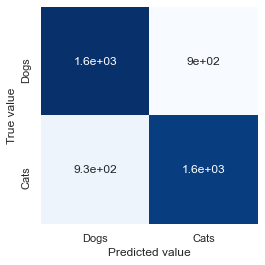

In [61]:
param_grid_AB={
    
    'model__n_estimators': [400,600,800],
    'model__learning_rate':[0.01,0.1,1],
    'pca__n_components':[100]
}

best_estimator_ab,cv_results_ab,train_pred_ab,y_train_ab,test_pred_ab,y_test_ab,cl_rep_ab=model_training(AdaBoostClassifier(base_estimator=tree),param_grid_AB,X_train,y_train,X_test,y_test)
show_results(best_estimator_ab,cv_results_ab,train_pred_ab,y_train_ab,test_pred_ab,y_test_ab,)

The resultant model has some overfitting. Train set score is 0.67, Validation set score is 0.64 and Test set score is 0.63. So, lets try to use less PCs. Also, the Grid search chose a value for the number of estimators 800 which is in the right end of the parameters interval. For the nexr Grid search attemp we will use the following values for number of estimators: [600,800,1000] (800 is put in the middle).

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=20, random_state=42)),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.1, n_estimators=1000))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([72.43271074, 97.03584495, 95.77939634, 57.17650671, 69.84292426,
       83.47841883, 55.47589188, 79.69372721, 85.28648219]), 'std_fit_time': array([ 1.25905557,  1.17957891, 12.20363384,  0.52476279,  0.12836864,
        0.55758437,  1.21060649,  6.2959343 ,  4.16326917]), 'mean_score_time': array([1.47185774, 1.70637012, 1.22574072, 0.96249781, 1.10441966,
       1.33193965, 0.99831862, 1.4446383 , 1.46688433]), 'std_score_time': array([0.09713521, 0.1216641 , 0.04928573, 0.08616346, 0.05189946,
 

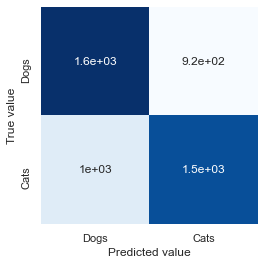

In [62]:
param_grid_AB={
    
    'model__n_estimators': [600,800,1000],
    'model__learning_rate':[0.01,0.1,1],
    'pca__n_components':[20]
}

best_estimator_ab,cv_results_ab,train_pred_ab,y_train_ab,test_pred_ab,y_test_ab,cl_rep_ab=model_training(AdaBoostClassifier(base_estimator=tree),param_grid_AB,X_train,y_train,X_test,y_test)
show_results(best_estimator_ab,cv_results_ab,train_pred_ab,y_train_ab,test_pred_ab,y_test_ab,)

The overfitting decreased but didn't disappear completely. Another parameter grid search will be performed with different values for n_estimators.

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=15, random_state=42)),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.1, n_estimators=1200))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([58.05250835, 70.27142076, 77.67219934, 55.52064285, 64.1197722 ,
       79.85533986, 57.42213144, 69.88204417, 76.50875783]), 'std_fit_time': array([0.44235993, 2.46609196, 1.39821211, 1.41616966, 0.60781476,
       2.6020304 , 1.30414033, 0.40422543, 8.88865675]), 'mean_score_time': array([1.19536457, 1.30798936, 1.41200385, 1.08848186, 1.25054531,
       1.48427696, 1.57573071, 1.71137462, 1.72614737]), 'std_score_time': array([0.03507312, 0.08170316, 0.09907639, 0.09679861, 0.18199268,
       0.1

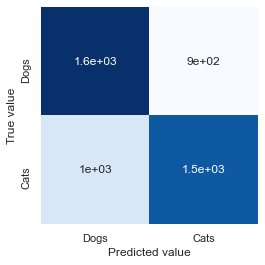

In [63]:
param_grid_AB={
    
    'model__n_estimators': [800,1000,1200],
    'model__learning_rate':[0.01,0.1,1],
    'pca__n_components':[15]
}

best_estimator_ab,cv_results_ab,train_pred_ab,y_train_ab,test_pred_ab,y_test_ab,cl_rep_ab=model_training(AdaBoostClassifier(base_estimator=tree),param_grid_AB,X_train,y_train,X_test,y_test)
show_results(best_estimator_ab,cv_results_ab,train_pred_ab,y_train_ab,test_pred_ab,y_test_ab,)

Again the model with number of estimators = 1000 and learning rate=0.1 is chosen. Which will be the final AdaBoost algorithm. 

_______________________________________________________________________
BEST ESTIMATOR
Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=15, random_state=42)),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.1, n_estimators=1000))])
_______________________________________________________________________
CV RESULTS
{'mean_fit_time': array([75.07097497]), 'std_fit_time': array([6.97073887]), 'mean_score_time': array([1.52618704]), 'std_score_time': array([0.20597105]), 'param_model__learning_rate': masked_array(data=[0.1],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_model__n_estimators': masked_array(data=[1000],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_pca__n_components': masked_array(data=[15],
             mask=[False],
       fill_value='?',
        

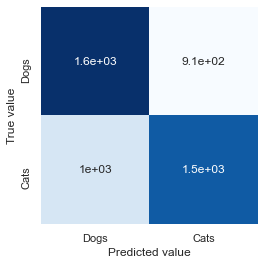

In [64]:
param_grid_AB={
    
    'model__n_estimators': [1000],
    'model__learning_rate':[0.1],
    'pca__n_components':[15]
}

best_estimator_ab,cv_results_ab,train_pred_ab,y_train_ab,test_pred_ab,y_test_ab,cl_rep_ab=model_training(AdaBoostClassifier(base_estimator=tree),param_grid_AB,X_train,y_train,X_test,y_test)
show_results(best_estimator_ab,cv_results_ab,train_pred_ab,y_train_ab,test_pred_ab,y_test_ab,)

And finally the learning curve. Train set score is 0.64, validation set score is 0.62 and test set score is 0.61

In [65]:
params_AB={
    
    'model__n_estimators': [1000],
    'model__learning_rate':[0.1],
    'pca__n_components':[20]
}


Validation error:  [0.43, 0.42, 0.39, 0.41, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.38, 0.38, 0.39, 0.38, 0.39, 0.38, 0.39, 0.38]
Train error:  [0.17, 0.25, 0.28, 0.3, 0.32, 0.32, 0.33, 0.34, 0.35, 0.34, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.36, 0.35, 0.35, 0.35]
Test error:  [0.44, 0.39, 0.41, 0.4, 0.37, 0.4, 0.4, 0.39, 0.39, 0.39, 0.39, 0.37, 0.38, 0.38, 0.38, 0.39, 0.38, 0.38, 0.38, 0.38]


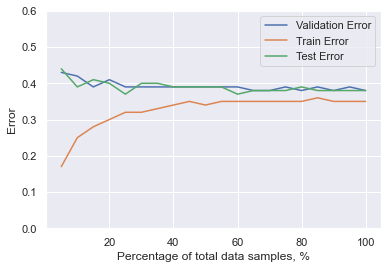

In [66]:
draw_learning_curve(AdaBoostClassifier(),params_AB)

| Model          | Train set score | Validation set score |
|----------------|-----------------|----------------------|
| Log Regression | 0.61            | **0.60**             |
| Random Forest  | 0.62            | **0.60**             |
| AdaBoost       | 0.64            | **0.62**             |

The Validation score is best for AdaBoost. Though the overfitting is little bit bigger than for Logistic Regression, AdaBoost will be our final choice. Now, the chosen algorithm will be run (once again) on the test set.

These are the parameters of the final model:

In [67]:
params_AB={
    
    'model__n_estimators': [1000],
    'model__learning_rate':[0.1],
    'pca__n_components':[20]
}

In [68]:
tree=DecisionTreeClassifier(max_depth=1)
scaler=StandardScaler()
pca=PCA(n_components=20)
ada=AdaBoostClassifier(base_estimator=tree,n_estimators=1000,learning_rate=0.1)
pipe=Pipeline(steps=[('scaler',scaler),('pca',pca),('model',ada)])
pipe.fit(X_train,y_train)
 
train_pred=pipe.predict(X_train)
test_pred=pipe.predict(X_test)


In [69]:
print ("The Test score (f1) is: ",round(f1_score(y_test,test_pred,average='macro'),2))

The Test score (f1) is:  0.62


In [71]:
print ("The Train score (f1) is: ",round(f1_score(y_train,train_pred,average='macro'),2))

The Train score (f1) is:  0.64


Finally, we will export the trained model to a file, so it can be used outside this project.

In [72]:
model_export='Final_AdaBoost.sav'

In [73]:
pickle.dump(pipe,open(model_export,'wb'))

And in order to be able to use the model with any pictures we might have in a folder, a function will be created for importing the images and preparing them for input. Fuction will be very similar to import_pictures defined above, only without the labelling of the samples.

In [74]:
test_data_folder='data/test_cats_dogs/'

In [75]:
def import_testing_data(image_size):
     
    test_images=[]
    
    for file in os.listdir(test_data_folder):
        img=cv2.imread(test_data_folder+str(file),cv2.IMREAD_COLOR)
        img_hsv=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
        img=cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
        img_resized=cv2.resize(img,(image_size,image_size)).ravel()
        test_images.append(img_resized)
        
    test_images=np.array(test_images)
    
    np.random.shuffle(test_images)
    
    return test_images

#### Here is how the process of using the saved model works. 

The image size is not choosable by the user, it is fixed and equal to the sized used for training the model.

In [76]:
image_size=40

Then we import the new new "unseen" data set by using the import_testing_data function which makes the image preprocessing (histogram equalization).

In [77]:
test_images=import_testing_data(image_size)

Next, the model is loaded from the file.

In [78]:
loaded_model=pickle.load(open(model_export,'rb'))

We make prediction with the saved model and put the results in the results variable. 

In [79]:
results=loaded_model.predict(test_images)

Down, we can see how the prediction works on 5 random images. Due to the small size of the picture for some it is difficult for the human eye to recognize if it is cat or dog, but increasing the size of pictures leads to very long working time. That's why size is kept 40x40 pixels.

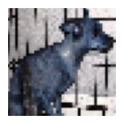

Dog


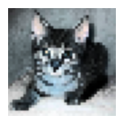

Cat


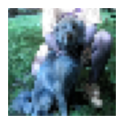

Cat


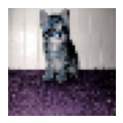

Cat


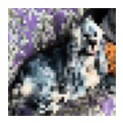

Dog


In [80]:
animals={0:'Dog',
        1:'Cat'}
for num_pics in range(5):
    i=random.randint(0,len(results)-1)
    image = test_images[i]
    image.resize((image_size,image_size,3))
    image=np.array(image,dtype='uint8')
    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.show()
    
    print(animals[results[i]])

### References


[1] Aurelien Geron. Hands-on Mashine Learning with Scikit-Learn and TensorFlow. O'Reily, 2017.

[2] https://medium.com/machine-learning-101/chapter-3-decision-trees-theory-e7398adac567

[3] Wikipedia

[4] https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952

[5] https://towardsdatascience.com/understanding-random-forest-58381e0602d2https://towardsdatascience.com/understanding-random-forest-58381e0602d2